# Проект: Определение возраста покупателей

## Описание проекта

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Загрузим и изучим данные.

Загружаем необходимые библиотеки для работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Создадим объект класса ImageDataGenerator для выгрузки файлов с фотографиями и сохраним данные в переменной data.

In [2]:
datagen = ImageDataGenerator()

In [3]:
pictures = datagen.flow_from_directory('/datasets/faces/')

Found 7591 images belonging to 1 classes.


Сохраним в отдельной переменной таблицу с названием фотографии и соответствующим возрастом человека на этой фотографии.

In [4]:
age_file = pd.read_csv('/datasets/faces/labels.csv')
age_file

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


### Выведем первые 10 фотографий на экран

Изучим первые 10 фотографий в датасете и изучим особенности.

4


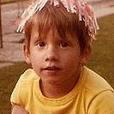

18


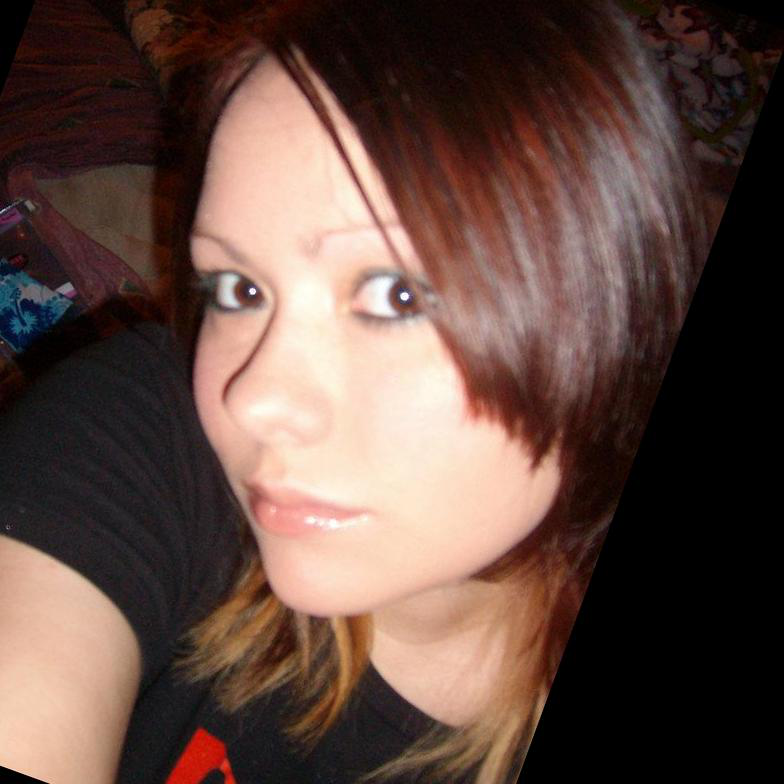

80


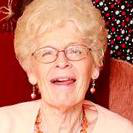

50


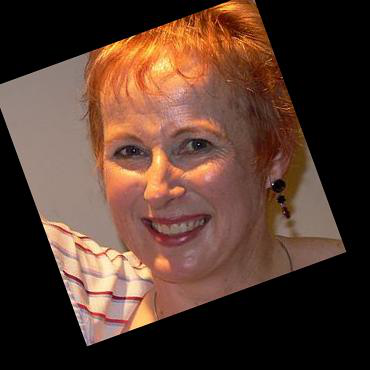

17


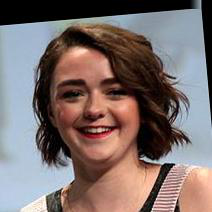

27


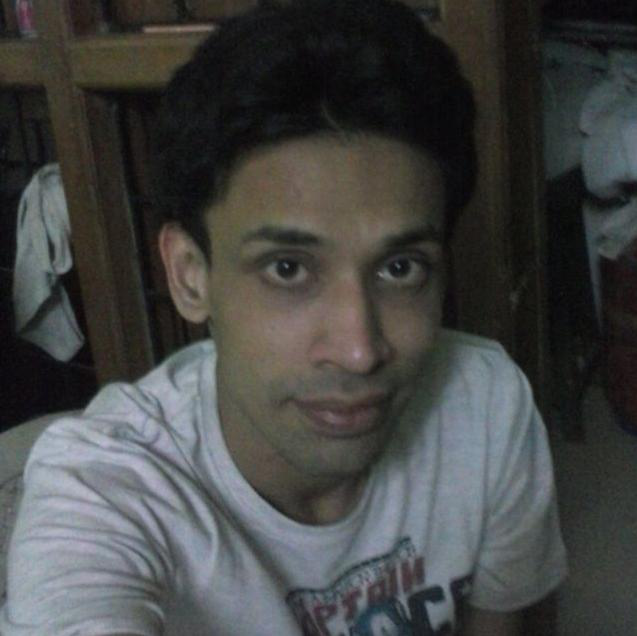

24


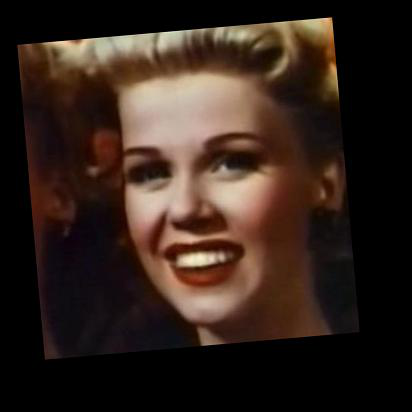

43


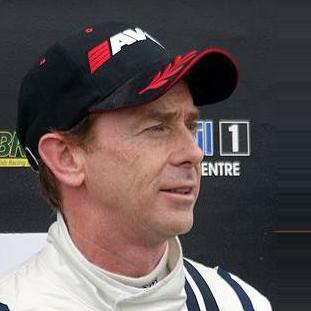

26


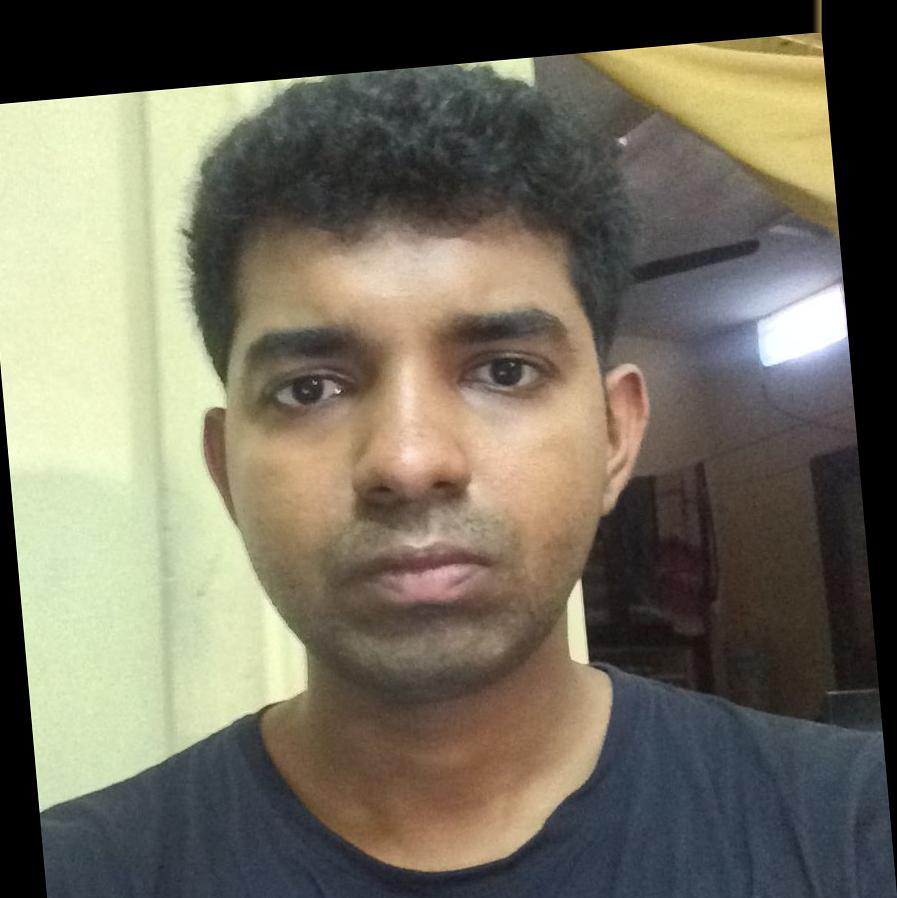

39


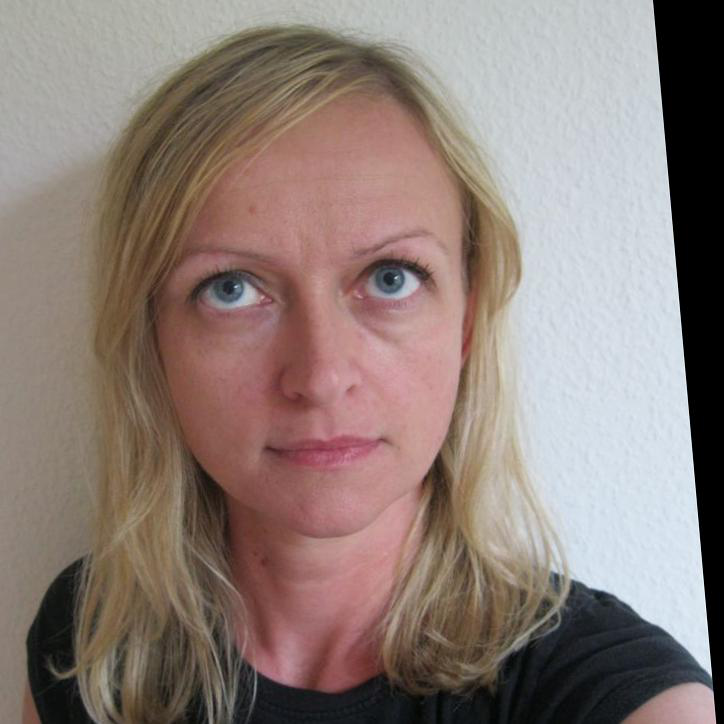

In [5]:
for i in range(10):
    file_name = age_file.file_name[i]
    image = Image.open('/datasets/faces/final_files/' + file_name)
    print(age_file.real_age[i])
    display(image)

**Наблюдения:**
1) Все фотографии разного размера. При обучении нейросети нужно будет привести их к одному размеру.  

2) Многие фотографии развернуты на разное кол-во градусов. Мне кажется, таким образом выравнивали фотографии, чтобы лицо на фотографиях было не наклонено.  

3) Визуально возраст совпадает в таблице и на картинке.  

4) Кол-во картинок и наблюдений по возрасту совпадает.  

### Изучим распределение возраста в данных.

Построим график распределения возраста среди всех фотографий. Также выведем информационные таблицы с рапределением значений.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Доля наблюдений разных возрастов')

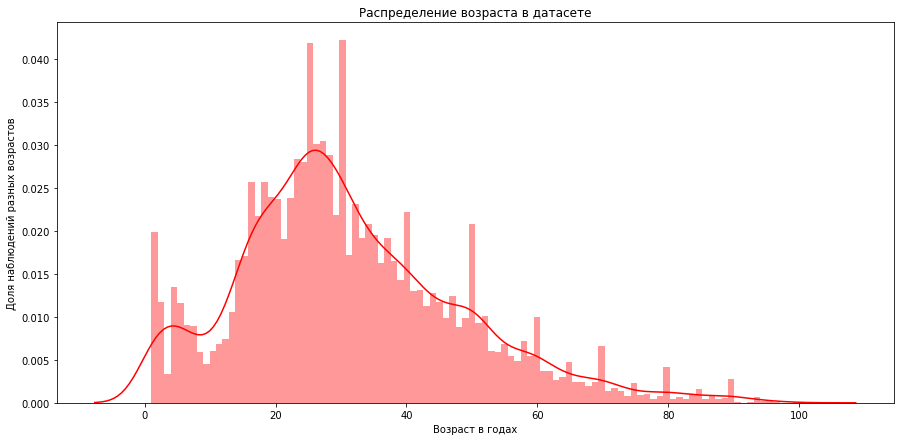

In [6]:
plt.figure(figsize=(15,7))
sns.distplot(age_file.real_age, hist=True, bins=100, color='red')
plt.title('Распределение возраста в датасете')
plt.xlabel('Возраст в годах')
plt.ylabel('Доля наблюдений разных возрастов')

In [7]:
age_file.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [8]:
age_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


**Наблюдения:**  
1) Распределение ненормальное с отклонением влево.  

2) Имеется два пика. Основной пик приходится примерно на 23-24 года. Второй - в районе 1-2 лет.  

3) Чаще картинки имеют возраст, кратный 5. Об этом говорят пики в районе 25, 30 лет и так далее. Скорее всего, тот, кто размечал датасет указывал примерный возраст, если не знал его наверняка.  

4) Диапазон значений: от 1 до 100 включительно.  

5) Все значения целые. Об этом нам говорит тип колонки с возрастом: integer.

Увеличение выборки с фотографиями несовершеннолетних людей вполне логично. Одна из задач обучения модели - определение по фотографиям камеры в прикассовой зоне совершеннолетний ли человек. Поэтому устранять этот пик не будем.  

Важно, что бы у модели было достаточно данных, чтобы понять разницу между ребенком и взрослым.

**Выводы исследовательского анализа:**

1. При обучении модели потребуется приведение фотографий к единому размеру.  

2. Разворот фотографий не требуется, так как он уже выполнен в датасете.  

3. Так же нужно рассмотреть дополнительные варианты увеличения выборки. Варианты аугментации:  
    - Изменение яркости  
    - Отражение по горизонтали  

## Обучение модели

Мы используем **нейронную сеть типа ResNes50** из библиотеки Keras и обучим ее в GPU-тренажере. Далее будет вставка кода с сетью и ее вывод с результатом обучения.  

Из-за особенностей использования GPU-тренажера нам нужно было разделить загрузку датасета, его преобразование, создание слоев нейронки и ее обучение на разные функции. Тренажер принимает ее только в таком виде.

**Описание нейронной сети:**

```python
import pandas as pd
import numpy as np

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       validation_split=0.25, 
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                                    pd.read_csv(path + 'labels.csv'),
                                                    path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='training', 
                                                    seed=12345)
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255,
                                      validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
                                                    pd.read_csv(path + 'labels.csv'),
                                                    path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    class_mode='raw',
                                                    subset='validation', 
                                                    seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

**Вывод нейронной сети:**

```
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/10
2023-10-19 17:52:02.351588: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-10-19 17:52:02.644214: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 233.9352 - mae: 10.9921 - val_loss: 525.6029 - val_mae: 17.8399
Epoch 2/10
356/356 - 39s - loss: 86.7201 - mae: 7.0852 - val_loss: 188.5860 - val_mae: 10.3298
Epoch 3/10
356/356 - 39s - loss: 57.2671 - mae: 5.7734 - val_loss: 83.6910 - val_mae: 6.8523
Epoch 4/10
356/356 - 39s - loss: 43.9598 - mae: 5.0688 - val_loss: 101.4607 - val_mae: 7.9507
Epoch 5/10
356/356 - 39s - loss: 34.2672 - mae: 4.4254 - val_loss: 89.9164 - val_mae: 6.9640
Epoch 6/10
356/356 - 39s - loss: 25.0742 - mae: 3.8201 - val_loss: 66.7570 - val_mae: 6.1008
Epoch 7/10
356/356 - 39s - loss: 21.9976 - mae: 3.5762 - val_loss: 72.0825 - val_mae: 6.4709
Epoch 8/10
356/356 - 39s - loss: 18.4968 - mae: 3.2783 - val_loss: 67.4236 - val_mae: 6.2770
Epoch 9/10
356/356 - 43s - loss: 16.4485 - mae: 3.0819 - val_loss: 65.7443 - val_mae: 6.1863
Epoch 10/10
356/356 - 42s - loss: 13.5186 - mae: 2.7835 - val_loss: 66.3841 - val_mae: 6.0144
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 66.3841 - mae: 6.0144
Test MAE: 6.0144
```

## Анализ обученной модели

- Для предсказаний мы использовали нейронную сеть ResNes50 с 50 различными слоями под корпусом.   

- Мы привели значения пикселей к диапазону от 0 до 1 для ускорения работы сети.  

- Мы добавили аугментацию: отражение по горизонтали. Не использовали наклон, так как он уже был использован заранее в датасете.  
- Привели все фотографии к единому размеру: 224 x 224 пикселя.  

- Функция потерь: средняя квадратная ошибка, и  метрика для оценки модели на валидационных данных: средняя абсолютная ошибка.  

- **Модель показала хороший результат: MAE = 6,01 на валидационных данных.** Это значит, что модель ошибается в среднем на 6 лет.